In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import pickle
import seaborn as sns
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import Lasso
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

pd.set_option('display.float_format', lambda x: '%.5f' % x)

categorical = ['PULocationID', 'DOLocationID']
numerical = ['trip_distance']
target = 'duration'

In [2]:
import mlflow

mlflow.set_tracking_uri("sqlite:///mlflow.db")
mlflow.set_experiment("nyc-taxi-experiment")

<Experiment: artifact_location='/workspaces/mlops-zoomcamp/02-experiment-tracking/mlruns/1', creation_time=1716819305993, experiment_id='1', last_update_time=1716819305993, lifecycle_stage='active', name='nyc-taxi-experiment', tags={}>

## Full base

In [3]:
URL_DATASET_JANUARY = 'https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2023-01.parquet'
URL_DATASET_FEBRUARY = 'https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2023-02.parquet'

df = pd.read_parquet(URL_DATASET_JANUARY)
print(f'Number of columns: {len(df.columns)}')

df.tpep_pickup_datetime = pd.to_datetime(df.tpep_pickup_datetime)
df.tpep_dropoff_datetime = pd.to_datetime(df.tpep_dropoff_datetime)

df['duration'] = df.tpep_dropoff_datetime - df.tpep_pickup_datetime
df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)

print(f'Standard deviation: {df.duration.std()}')

Number of columns: 19
Standard deviation: 42.59435124195458


## Remove outliers

In [4]:
def read_dataframe(url)->pd.DataFrame:
    df = pd.read_parquet(url)

    df.tpep_pickup_datetime = pd.to_datetime(df.tpep_pickup_datetime)
    df.tpep_dropoff_datetime = pd.to_datetime(df.tpep_dropoff_datetime)

    df['duration'] = df.tpep_dropoff_datetime - df.tpep_pickup_datetime
    df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)

    df = df[(df.duration >= 1) & (df.duration <= 60)]

    df[categorical] = df[categorical].astype(str)
    
    return df

df_train = read_dataframe(URL_DATASET_JANUARY)

print(f'Fraction of the records left : {df_train.shape[0] / df.shape[0] * 100}')

Fraction of the records left : 98.1220282212598


In [5]:
# Training pipeline
train_dicts = df_train[categorical + numerical].to_dict(orient='records')

dv = DictVectorizer()
X_train = dv.fit_transform(train_dicts)

print(f'Dimensionality of matrix: {len(dv.feature_names_)}')

y_train = df_train[target].values

lr = LinearRegression()
lr.fit(X_train, y_train)

Dimensionality of matrix: 516


LinearRegression()

In [6]:
# Prediction on training dataset
y_pred = lr.predict(X_train)

# Evaluation on training dataset
print(f'Training dataset RMSE: {mean_squared_error(y_train, y_pred, squared=False)}')

Training dataset RMSE: 7.6583961794392525


/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


## Validation

In [7]:
# Validation
df_validation = read_dataframe(URL_DATASET_FEBRUARY)

validation_dicts = df_validation[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(validation_dicts)

# Prediction on validation dataset
y_pred = lr.predict(X_val)

# Evaluation on training dataset
y_train = df_validation[target].values
print(f'Validation dataset RMSE: {mean_squared_error(y_train, y_pred, squared=False)}')

Validation dataset RMSE: 7.820270163704565


/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


/tmp/ipykernel_5663/1376732626.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_pred, label='prediction')
/tmp/ipykernel_5663/1376732626.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_train, label='actual_value')


<function matplotlib.pyplot.legend(*args, **kwargs) -> 'Legend'>

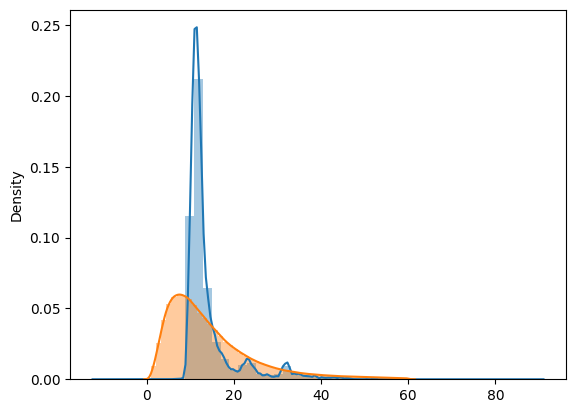

In [8]:
# sns.distplot(y_pred, label='prediction')
# sns.distplot(y_train, label='actual_value')
# plt.legend

## Save model

In [9]:
with open('models/lin_reg.bin', 'wb') as f_out:
    pickle.dump((dv, lr), f_out)

In [12]:
from sklearn.linear_model import Lasso

with mlflow.start_run():
    mlflow.set_tag('developer', 'Quentin')
    mlflow.log_param('train-data', 'yellow_tripdata_2023-01.parquet')
    mlflow.log_param('validation-data', 'yellow_tripdata_2023-02.parquet')
    
    alpha = 0.01
    mlflow.log_param('alpha', alpha)

    lr = Lasso(alpha)
    lr.fit(X_train, y_train)

    y_pred = lr.predict(X_val)
    rmse = mean_squared_error(y_train, y_pred, squared=False)
    mlflow.log_metric('rmse', rmse)


ValueError: Found input variables with inconsistent numbers of samples: [3009173, 2855951]